Notebook to identify the changes of direction per player

In [ ]:
import numpy as np
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt
from math import sqrt, degrees, atan ,atan2, acos
from mplsoccer import Pitch
from mplsoccer.dimensions import valid

In [7]:
base_path = Path("SecondSpectrum/Second Spectrum")

In [8]:
game_path = Path("Anderlecht - Club Brugge")

In [13]:
# path to the tracking data file
xy_path = Path(base_path, game_path, "xy_HT1.parquet")

In [10]:
# secondspectrum pitch dimensions
#"pitchLength": 103.4589780029297
#"pitchWidth": 66.97553049316407

In [16]:
# read the velocity data
xy_df = pl.read_parquet(xy_path)

In [17]:
xy_df

S. Mignolet_x,S. Mignolet_y,Ordoñez_x,Ordoñez_y,Ferran Jutglà_x,Ferran Jutglà_y,K. Sabbe_x,K. Sabbe_y,C. Talbi_x,C. Talbi_y,H. Vanaken_x,H. Vanaken_y,B. Mechele_x,B. Mechele_y,C. Tzolis_x,C. Tzolis_y,Maxim De Cuyper_x,Maxim De Cuyper_y,Ardon Jashari_x,Ardon Jashari_y,Raphael Onyedika_x,Raphael Onyedika_y,Bjorn Meijer_x,Bjorn Meijer_y,Michal Skoras_x,Michal Skoras_y,J. Spileers_x,J. Spileers_y,C. Nielsen_x,C. Nielsen_y,Romero_x,Romero_y,H. Vetlesen_x,H. Vetlesen_y,Siquet_x,Siquet_y,Jackers_x,Jackers_y,Romeo Vermant_x,Romeo Vermant_y,Gustaf Nilsson_x,Gustaf Nilsson_y
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
42.22,-0.24,8.87,5.31,-0.16,-22.24,11.01,12.63,0.09,9.1,0.45,-30.18,25.92,-3.65,0.16,-15.82,6.17,-16.74,-0.2,-0.14,6.25,-7.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42.21,-0.24,8.88,5.31,-0.23,-22.23,11.0,12.63,0.09,9.09,0.45,-30.19,25.92,-3.65,0.15,-15.82,6.17,-16.75,-0.17,-0.15,6.26,-7.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42.21,-0.23,8.88,5.3,-0.31,-22.22,10.99,12.64,0.09,9.09,0.44,-30.19,25.91,-3.65,0.13,-15.82,6.17,-16.75,-0.14,-0.16,6.27,-7.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42.2,-0.22,8.88,5.3,-0.4,-22.2,10.98,12.65,0.09,9.08,0.42,-30.18,25.91,-3.65,0.11,-15.82,6.17,-16.76,-0.12,-0.17,6.27,-7.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42.19,-0.21,8.88,5.29,-0.5,-22.18,10.97,12.66,0.09,9.07,0.38,-30.19,25.91,-3.65,0.08,-15.82,6.18,-16.76,-0.1,-0.18,6.28,-7.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
31.92,6.48,19.09,10.75,15.56,17.2,15.43,26.0,16.08,22.29,16.71,20.77,17.41,20.83,0.83,-20.73,18.02,10.19,18.99,9.89,16.12,13.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31.92,6.43,19.09,10.75,15.55,17.2,15.43,25.96,16.07,22.26,16.7,20.73,17.42,20.81,0.83,-20.73,18.01,10.16,18.99,9.87,16.11,13.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31.92,6.38,19.09,10.74,15.55,17.19,15.41,25.92,16.06,22.23,16.69,20.69,17.42,20.79,0.83,-20.73,18.0,10.12,18.99,9.85,16.11,13.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
player_names=[]
for col in xy_df.columns:
    splitted = col.split("_")
    if splitted[0] not in player_names:
        player_names.append(splitted[0])

print(player_names)

['S. Mignolet', 'Ordoñez', 'Ferran Jutglà', 'K. Sabbe', 'C. Talbi', 'H. Vanaken', 'B. Mechele', 'C. Tzolis', 'Maxim De Cuyper', 'Ardon Jashari', 'Raphael Onyedika', 'Bjorn Meijer', 'Michal Skoras', 'J. Spileers', 'C. Nielsen', 'Romero', 'H. Vetlesen', 'Siquet', 'Jackers', 'Romeo Vermant', 'Gustaf Nilsson']


In [19]:
xy_dict = {}

for player_name in player_names:
    xy_dict[player_name] = {}
    
    xcol = player_name + "_x"
    ycol = player_name + "_y"
    
    xy_dict[player_name]["x"] = xy_df[xcol]
    xy_dict[player_name]["y"] = xy_df[ycol]

In [20]:
#xy_dict['Amuzu']['x']

In [21]:
#x = xy_df.get_column("Amuzu_x").to_list()
#y = xy_df.get_column("Amuzu_y").to_list()

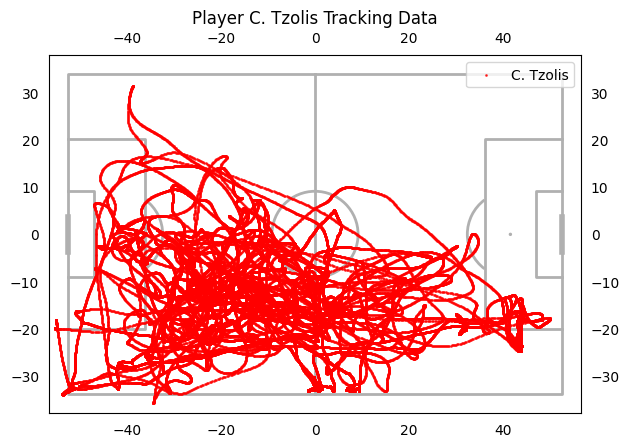

In [38]:
player = "C. Tzolis"
pitch = Pitch(pitch_type='secondspectrum', pitch_length=105, pitch_width=68,
              axis=True, label=True)#, pitch_color='grass', line_color='white', stripe_color='#c2d59d', stripe=True)
fig, ax = pitch.draw()

ax.scatter(xy_dict[player]['x'], xy_dict[player]['y'], c='red', s=1, label=player, alpha=0.7)

# Optional: add legend and title
ax.legend()
plt.title(f'Player {player} Tracking Data')

plt.show()

In [ ]:
#print(xy_dict['Amuzu']['x'])
#print(xy_dict['Amuzu']['y'])

In [39]:
player = "C. Tzolis"
print(min(xy_dict[player]['x']))
print(max(xy_dict[player]['x']))
print(min(xy_dict[player]['y']))
print(max(xy_dict[player]['y']))

-55.23
49.98
-35.78
31.52


Kai et al 2021: A new approach to quantify angles and time of changes-of-direction during soccer matches

-done-

In [40]:
# testing variables to use as input for a small scale test
x_test = [-12,-9,-6,-3,0,3,5,6,7,8,9,10,10,10,10,10,10,10,10,10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 12, 14, 16, 19, 22, 22, 22]
y_test = [0,0,0,0,0,0,0,0,0,0,0,1,2,4,6,9,12,13,14, 15, 15.5, 16, 16.5, 17, 17.5, 18, 18.5, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
print(x_test)
print(y_test)
#x_test.reverse()

[-12, -9, -6, -3, 0, 3, 5, 6, 7, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 12, 14, 16, 19, 22, 22, 22]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 6, 9, 12, 13, 14, 15, 15.5, 16, 16.5, 17, 17.5, 18, 18.5, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]


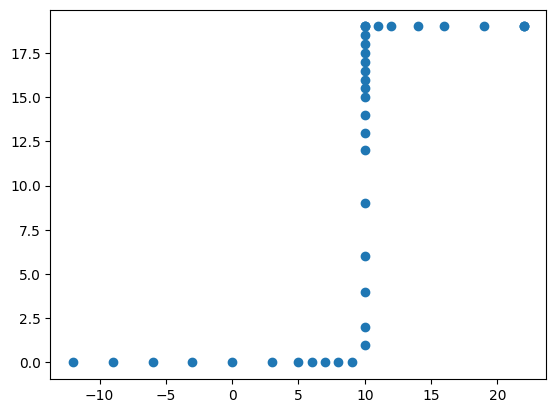

In [41]:
plt.scatter(x_test, y_test)

In [42]:
# define delta t = length of a frame
delta_t = 0.04

In [43]:
xy_dict.keys()

dict_keys(['S. Mignolet', 'Ordoñez', 'Ferran Jutglà', 'K. Sabbe', 'C. Talbi', 'H. Vanaken', 'B. Mechele', 'C. Tzolis', 'Maxim De Cuyper', 'Ardon Jashari', 'Raphael Onyedika', 'Bjorn Meijer', 'Michal Skoras', 'J. Spileers', 'C. Nielsen', 'Romero', 'H. Vetlesen', 'Siquet', 'Jackers', 'Romeo Vermant', 'Gustaf Nilsson'])

In [44]:
d_dict = {} # store direction of speed per player per frame 
v_dict = {} # store speed per frame

for player in xy_dict.keys():
    d_dict[player]=[]
    v_dict[player]=[]
    
    x=xy_dict[player]["x"]
    y=xy_dict[player]["y"]
    
    
    for i in range(len(x)): 
        if i>0 and i<len(x)-1:
            x1=x[i-1]
            y1=y[i-1]
            
            x2=x[i+1]
            y2=y[i+1]
            
            # atan return the arc tangent of x/y in radians
            # degrees converts the arctan to degrees
            d=degrees(atan2(y2 - y1, x2 - x1)) # alternative: arctan
            
            x_vector=(x2-x1)**2
            y_vector=(y2-y1)**2
            
            v=sqrt((x_vector+y_vector))/(delta_t*2)
            
        else: 
            d=0
            v=0
        
        d_dict[player].append(d)
        v_dict[player].append(v)
            
    d_dict[player][0]=d_dict[player][1] # equal angle in 1st frame to 2nd frame to avoid incorrect 0 angle      
    d_dict[player][-1]=d_dict[player][-2] # equal angle in last frame to 2nd last frame to avoid incorrect 0 angle
    
    v_dict[player][0]=v_dict[player][1] # equal speed in frame 2 to frame 1 to avoid incorrect 0 speed      
    v_dict[player][-1]=v_dict[player][-2] # equal speed in last frame to 2nd last frame to avoid incorrect 0 speed

    #print(min(d_list))    
    #print(max(d_list))
    

In [45]:
#len(d_dict["Amuzu"])
#len(v_dict["Amuzu"])
#range(len(v_dict["Amuzu"]))

In [ ]:
# not the standard formula --> takes the centered difference
a_dict = {} # store acceleration per player per frame

for player in v_dict.keys():
    a_dict[player] = []
    for i in range(len(v_dict[player])):
        if i>=1 and i<len(v_dict[player])-1: # only start calculations from 2nd element & avoid the last element to avoid false values
            v1=abs(v_dict[player][i-1]) # v_list[i-1]
            v2=abs(v_dict[player][i+1]) # v_list[i+1]
            
            #a=(sqrt((v2-v1)**2)/(delta_t*2)) # original formula of the paper --> seems wrong, a deceleration of 10m/s to 5m/s would be seen as an accelaration
            a=(v2-v1)/(delta_t*2) #test without the **2 & sqrt --> allowing negative values
            
        else: 
            a=0
        
        a_dict[player].append(a)
        
        #print(a)
        
    #print(min(a_list))    
    #print(max(a_list))

    a_dict[player][0]=a_dict[player][1] # equal speed in frame 2 to frame 1 to avoid incorrect 0 speed
    a_dict[player][-1]=a_dict[player][-2] # equal speed in last frame to 2nd last frame to avoid incorrect 0 speed

In [47]:
#a_list

In [48]:
# calculate jerk
j_dict = {} # store jerk per frame

for player in a_dict.keys():
    j_dict[player] = []
    
    for i in range(len(a_dict[player])):
        if i>=1 and i<len(a_dict[player])-1:
            a1=a_dict[player][i-1] # paper takes absolute value
            a2=a_dict[player][i+1] # paper takes absolute value
            
            #j=sqrt(((a2-a1)**2)/(2*delta_t))
            j=((a2-a1))/(2*delta_t)
            
        else: 
            j=0
        
        j_dict[player].append(j)

    j_dict[player][0]=j_dict[player][1] # equal jerk in frame 2 to frame 1 to avoid incorrect 0 jerk
    j_dict[player][-1]=j_dict[player][-2] # equal jerk in last frame to 2nd last frame to avoid incorrect 0 jerk

    #print(min(j_list))    
    #print(max(j_list))

In [50]:
#j_dict["Amuzu"]

In [51]:
player_name =  "C. Tzolis"

pl.Config.set_tbl_rows(5)
df = pl.DataFrame({
    "x": pl.Series("x", xy_dict[player_name]["x"], dtype=pl.Float64),
    "y": pl.Series("y", xy_dict[player_name]["y"], dtype=pl.Float64),
    "v": pl.Series("v", v_dict[player_name], dtype=pl.Float64),
    "a": pl.Series("a", a_dict[player_name], dtype=pl.Float64),
    "j": pl.Series("j", j_dict[player_name], dtype=pl.Float64),
    "d": pl.Series("d", d_dict[player_name], dtype=pl.Float64)
})
df


x,y,v,a,j,d
f64,f64,f64,f64,f64,f64
0.16,-15.82,0.375,1.5625,19.53125,180.0
0.15,-15.82,0.375,1.5625,19.53125,180.0
0.13,-15.82,0.5,3.125,78.125,180.0
…,…,…,…,…,…
0.83,-20.73,0.125,1.5625,0.0,90.0
0.83,-20.72,0.125,1.5625,0.0,90.0


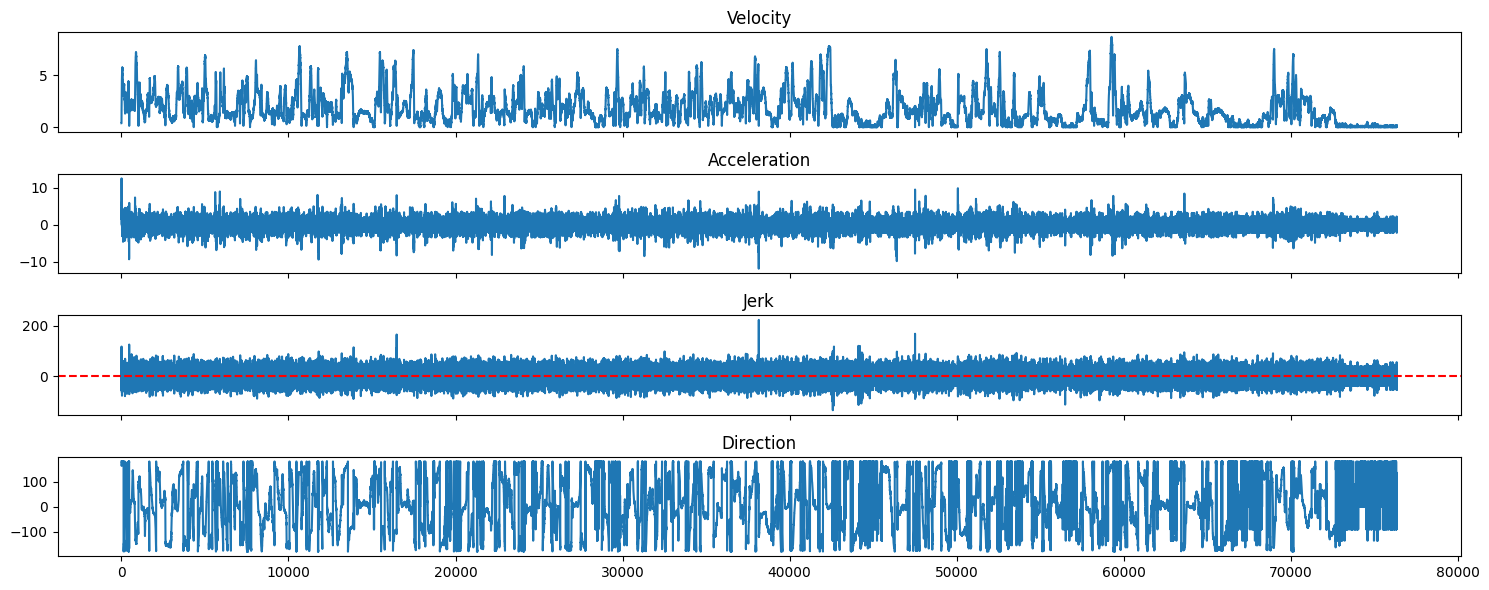

In [53]:
player="C. Tzolis"

x_ax = range(len(v_dict[player]))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize = [15,6])
#fig.suptitle("Tracking data metrics visualisation")
ax1.plot(x_ax, v_dict[player])
ax1.set_title("Velocity")
ax2.plot(x_ax, a_dict[player])
ax2.set_title("Acceleration")
ax3.plot(x_ax, j_dict[player])
ax3.set_title("Jerk")
ax3.axhline(0, color="red", linestyle = "--")
ax4.plot(x_ax, d_dict[player])
ax4.set_title("Direction")
fig.tight_layout()


In [54]:
# workflow
# 1_find jerk going from negative to positive
# 2_find jerk going together with direction change
# 3_check if there is a speed drop and deceleration (set cutoff)

In [ ]:
# each frame = 0.04s --> to get a stable  measurement --> take the average of 4 frames
# 1) start velocity above speed treshold | end velocity above speed treshold
# 2) start jerk = - | middle jerk = + | end jerk = -
# 3) absolute value of direction change greater than target change
# acceleration & deceleration treshold?
# start loop at frame 0 
# increase with 1 frame at a time until COD detection --> if COD go to next 2s window (+50 frames)

  
window_size=50
cod_dict={} # store the number of direction changes per player

for player in j_dict.keys():
    frame_counter=0 
    cod_count=0  
    
    while frame_counter<len(j_dict[player])-50 :  # ensure enough data remains for a full 2s window

        # Indices for 3 segments of 10 frames (0.4s each)
        start_1, start_2 = frame_counter, frame_counter+10
        middle_1, middle_2 = frame_counter+20, frame_counter+30
        end_1, end_2 = frame_counter+40, frame_counter+50

        # Averaging over the 10-frame segments
        j_start = np.mean(j_dict[player][start_1:start_2])
        v_start = np.mean(v_dict[player][start_1:start_2]) 
        d_start = np.mean(d_dict[player][start_1:start_2]) 

        j_middle = np.mean(j_dict[player][middle_1:middle_2]) 
        v_middle = np.mean(v_dict[player][middle_1:middle_2]) 
        d_middle = np.mean(d_dict[player][middle_1:middle_2]) 

        j_end = np.mean(j_dict[player][end_1:end_2]) 
        v_end = np.mean(v_dict[player][end_1:end_2]) 
        d_end = np.mean(d_dict[player][end_1:end_2]) 

        # Apply COD conditions
        if (
            v_start>4 and v_end>3  # velocity threshold at start and end
            and j_start<0 and j_middle>0 and j_end<0  # jerk pattern
            and abs(d_start-d_end)>45
        ):  # minimum directional change in degrees
            cod_count+=1
            frame_counter+=window_size # move to next 2-second window
            continue

        frame_counter+=1
    #print(cod_count)
    cod_dict[player] = cod_count
    

In [56]:
pl.from_dict(cod_dict)

S. Mignolet,Ordoñez,Ferran Jutglà,K. Sabbe,C. Talbi,H. Vanaken,B. Mechele,C. Tzolis,Maxim De Cuyper,Ardon Jashari,Raphael Onyedika,Bjorn Meijer,Michal Skoras,J. Spileers,C. Nielsen,Romero,H. Vetlesen,Siquet,Jackers,Romeo Vermant,Gustaf Nilsson
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
4,17,46,33,46,37,22,44,43,46,37,0,0,0,0,0,0,0,0,0,0


Brenda et al 2022: Quantifying change of direction load using positional data from small-sided games in soccer

-done-

In [57]:
# calculate the speed in the x and y direction per frame
vx_dict = {} # store speed in x direction per player per frame
vy_dict = {} # store speed in y direction per player per frame
v_dict_brenda = {} # store speed per player per frame

for player in xy_dict.keys():
    x=xy_dict[player]["x"]
    y=xy_dict[player]["y"]
    
    vx_dict[player] = [] 
    vy_dict[player] = [] 
    v_dict_brenda[player] = [] 
    
    for i in range(len(x)): 
        if i>0:
            vx=(x[i]-x[i-1])/delta_t
            vy=(y[i]-y[i-1])/delta_t
            v = sqrt((vx**2)+(vy**2))
            
        else: 
            vx=0
            vy=0
            v=0
            
        vx_dict[player].append(vx)
        vy_dict[player].append(vy)
        v_dict_brenda[player].append(v)
        
        #print(v)

    # equal speed in frame 2 to frame 1 to avoid incorrect 0 speed   
    vx_dict[player][0]=vx_dict[player][1] 
    vy_dict[player][0]=vy_dict[player][1] 
    v_dict_brenda[player][0]=v_dict_brenda[player][1] 

In [58]:
#v_dict_brenda["Amuzu"]

In [59]:
ha_dict = {} # list to store heading angles

for player in vx_dict.keys():
    ha_dict[player]=[]
    
    for i in range(len(vx_dict[player])):
        if vy_dict[player][i]==0 or vx_dict[player][i]==0: #division by 0 would give an error --> just assign 0 as heading angle
            ha=0
        else: # --> calculate heading angle using formula in brenda et al.2022
            vector=vy_dict[player][i]/vx_dict[player][i]
            ha=degrees(atan(vector))
        
        ha_dict[player].append(ha)

In [60]:
#ha_dict["Amuzu"]

define windows
--> window size = 1s = 25Hz

In [ ]:
k=0.003
v_25={}
heading_change_25={}
cod_dict_brenda={}
veloctity_curvature_cutoff={}
window_size=25 

for player in ha_dict.keys():
    frame_counter=0 
    cod_count = 0
    v_25[player]=[]
    heading_change_25[player]=[]
    veloctity_curvature_cutoff[player]=[]
    
    while frame_counter<len(ha_dict[player])-window_size:
        # calculate the average speed per window
        v=np.mean(v_dict_brenda[player][frame_counter:frame_counter+window_size])
        v_25[player].append(v)
        # calculate delta value of the heading change per window
        delta_ha=(ha_dict[player][frame_counter+window_size]-ha_dict[player][frame_counter])/(window_size*delta_t) # time delta = 1 second
        heading_change_25[player].append(delta_ha)
        # compute cutoff only if delta_ha is large enough
        if abs(delta_ha) >= 1:
            cutoff=1/(k*abs(delta_ha))
            
            if v>cutoff:
                cod_count+=1
                frame_counter+=window_size
                
            else:
                frame_counter+=1
              
        # extra option to calculate COD load using formula: load = v - cutoff    
        else:
            cutoff = np.nan  # mark as invalid or too small to matter
            frame_counter+=1
            
        veloctity_curvature_cutoff[player].append(cutoff)
        
    #print(cod_count)
    cod_dict_brenda[player]=cod_count

In [62]:
pl.from_dict(cod_dict_brenda)

S. Mignolet,Ordoñez,Ferran Jutglà,K. Sabbe,C. Talbi,H. Vanaken,B. Mechele,C. Tzolis,Maxim De Cuyper,Ardon Jashari,Raphael Onyedika,Bjorn Meijer,Michal Skoras,J. Spileers,C. Nielsen,Romero,H. Vetlesen,Siquet,Jackers,Romeo Vermant,Gustaf Nilsson
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
13,26,68,40,46,71,36,68,30,64,61,0,0,0,0,0,0,0,0,0,0


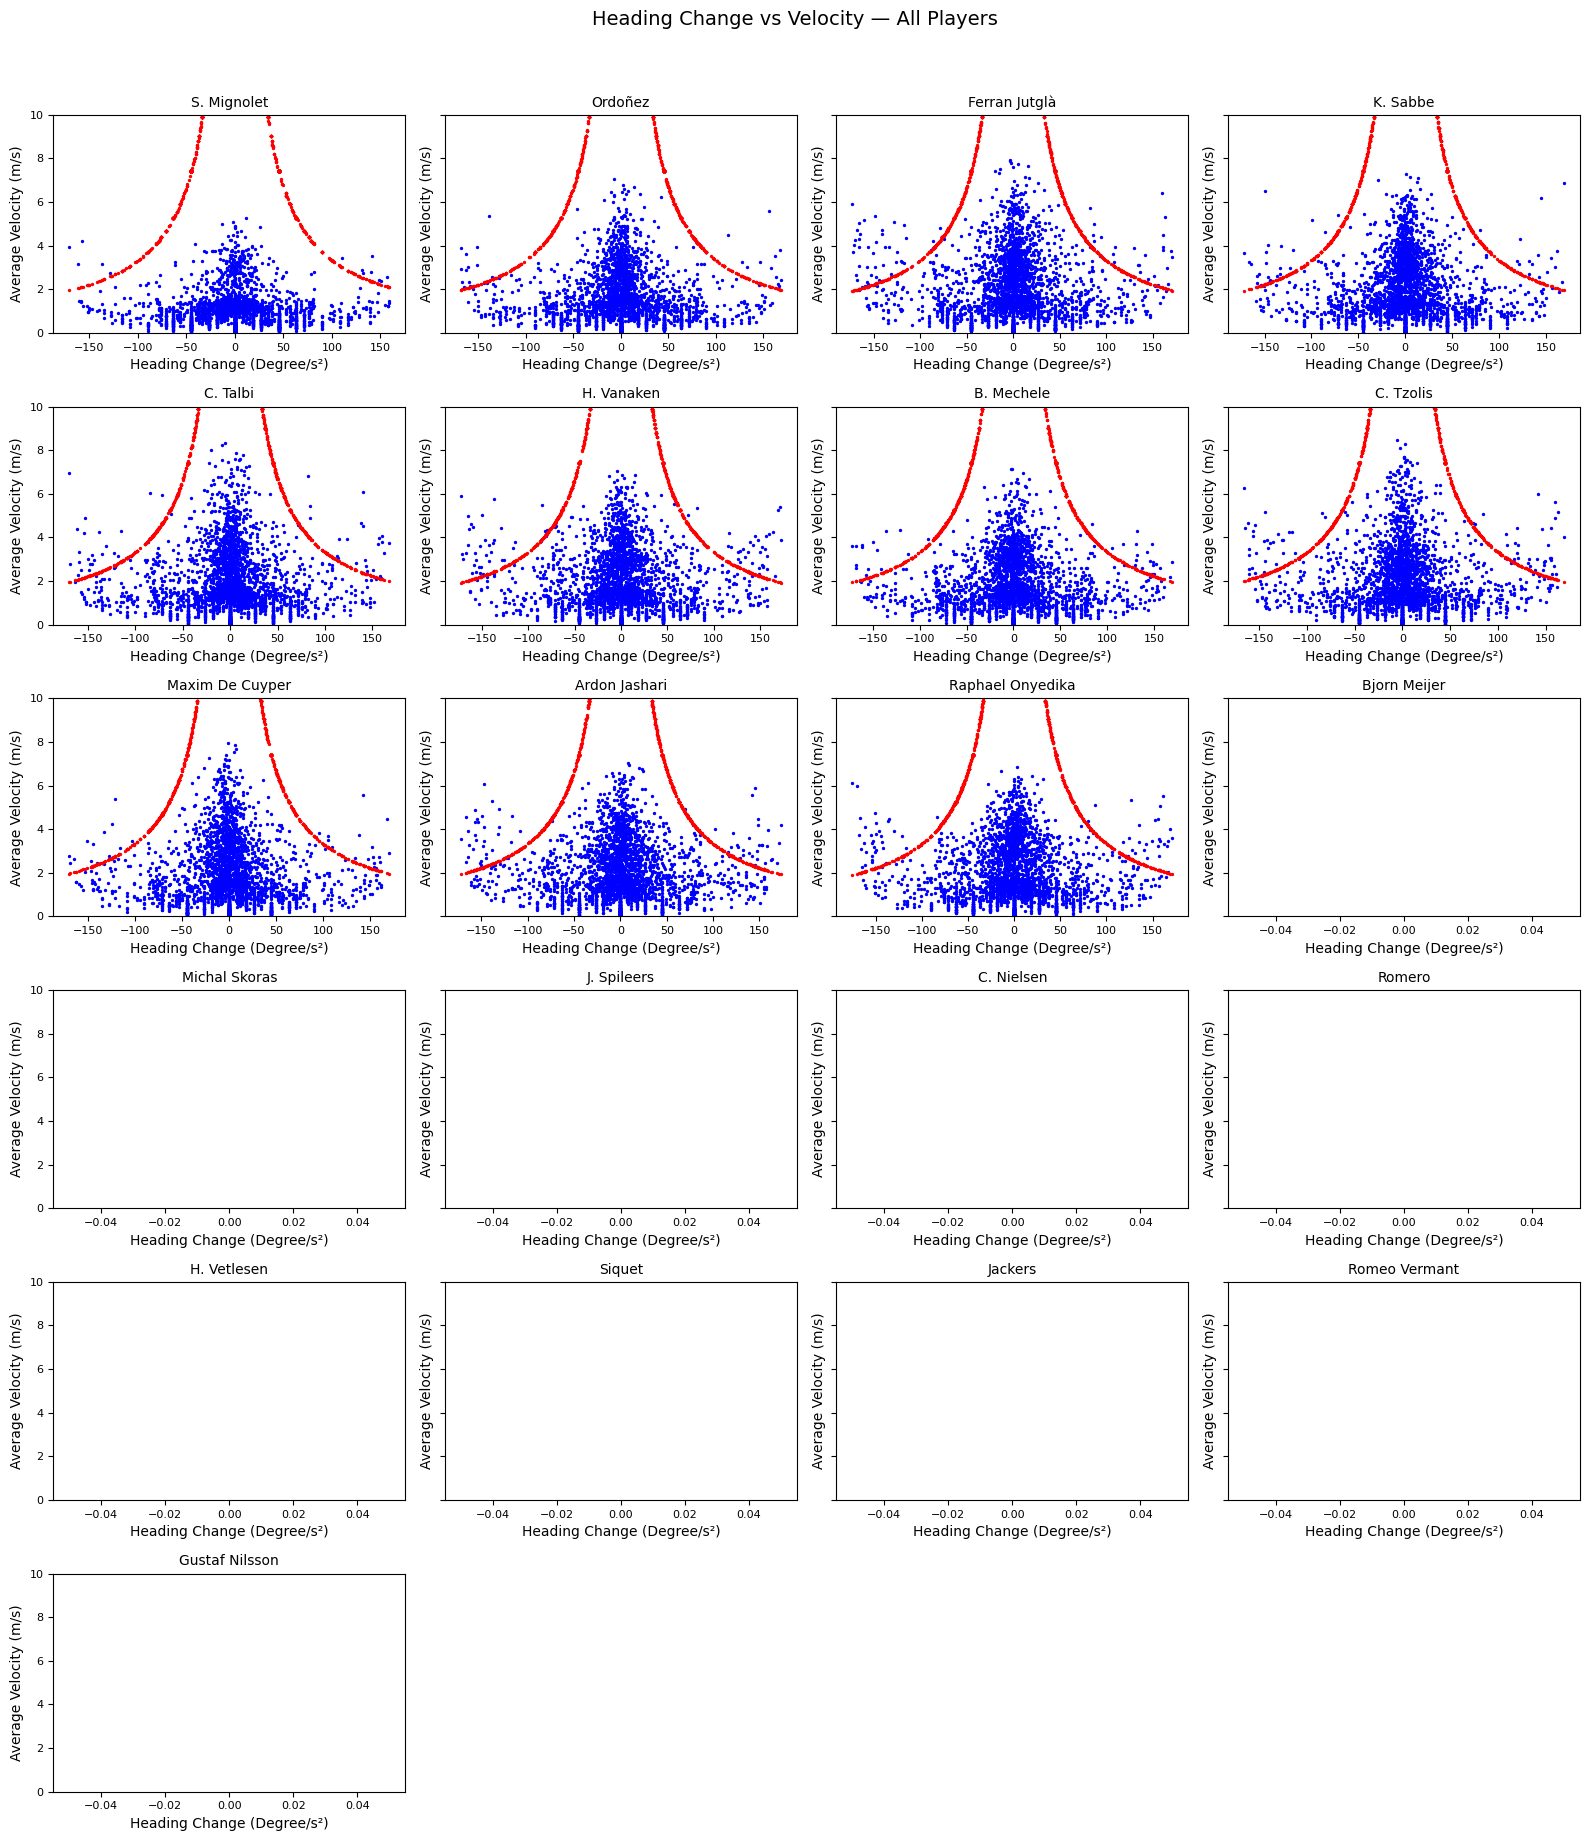

In [63]:
players = list(heading_change_25.keys())
n_players = len(players)

n_cols = 4
n_rows = -(-n_players // n_cols) # om naar boven af te ronden

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3), sharey=True)
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i, player in enumerate(players):
    ax = axes[i]
    ax.scatter(heading_change_25[player], v_25[player], s=2, label="v_25", color='blue')
    ax.scatter(heading_change_25[player], veloctity_curvature_cutoff[player], s=2, label="cutoff", color='red')
    ax.set_ylim(0, 10)
    ax.set_title(player, fontsize=10)
    ax.tick_params(labelsize=8)
    ax.set_ylabel('Average Velocity (m/s)')
    ax.set_xlabel('Heading Change (Degree/s²)')

# Hide unused subplots if there are fewer than n_rows * n_cols
for j in range(n_players, len(axes)):
    fig.delaxes(axes[j])

#axes.set_xlabel('Average Velocity (m/s)')
fig.suptitle("Heading Change vs Velocity — All Players", fontsize=14, y=1.02)

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Heading change and average velocity over 1 second windows')

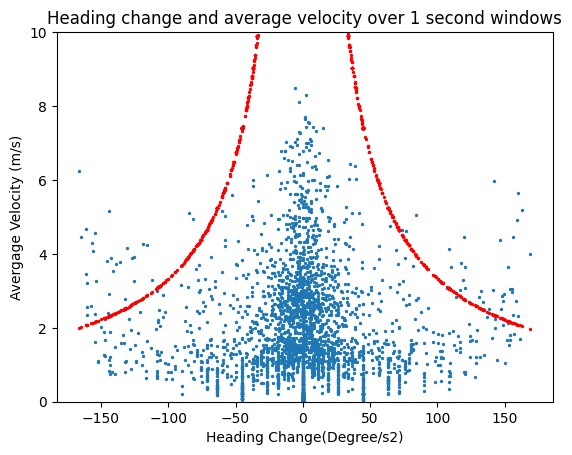

In [66]:
player = "C. Tzolis"
fig, ax = plt.subplots()
ax.scatter(heading_change_25[player], v_25[player], s=2)
ax.scatter(heading_change_25[player], veloctity_curvature_cutoff[player], s=2, color="red")
ax.set_ylim(0,10)
ax.set_ylabel("Avergage Velocity (m/s)")
ax.set_xlabel("Heading Change(Degree/s2)")
ax.set_title("Heading change and average velocity over 1 second windows")


Reilly et al. 2021:  Automated Classification of Changes of Direction in Soccer Using Inertial Measurement Units
- average time bbetween start & end COD = 3.1s
- COD angle as one of ‘0–45 DEG’, ‘45–90 DEG’, ‘90–135 DEG’, ‘135–180DEG’
- extra machine learning model based on video analysis

In [67]:
print(x)
print(y)

shape: (76_366,)
Series: 'Gustaf Nilsson_x' [f64]
[
	NaN
	NaN
	NaN
	…
	NaN
	NaN
]
shape: (76_366,)
Series: 'Gustaf Nilsson_y' [f64]
[
	NaN
	NaN
	NaN
	…
	NaN
	NaN
]


In [69]:
#print(len(xy_dict["Amuzu"]["x"]))
#print(len(v_dict["Amuzu"]))

In [ ]:
frame_counter=0
cod_counter=0
window_size=60
cod_dict_reilly={}

for player in xy_dict.keys():
    frame_counter = 0
    cod_count=0
    
    while frame_counter<len(x)-60:    
        x1=sum(xy_dict[player]["x"][frame_counter:frame_counter+10])/10
        y1=sum(xy_dict[player]["y"][frame_counter:frame_counter+10])/10
        v1=sum(v_dict[player][frame_counter:frame_counter+10])/10
            
        x2=sum(xy_dict[player]["x"][frame_counter+25:frame_counter+35])/10
        y2=sum(xy_dict[player]["y"][frame_counter+25:frame_counter+35])/10
        v2=sum(v_dict[player][frame_counter+25:frame_counter+35])/10
                
        x3=sum(xy_dict[player]["x"][frame_counter+50:frame_counter+window_size])/10
        y3=sum(xy_dict[player]["y"][frame_counter+50:frame_counter+window_size])/10
        v3=sum(v_dict[player][frame_counter+50:frame_counter+window_size])/10

        a=sqrt(((x2-x3)**2)+((y2-y3)**2)) # distance between 2nd and 3th points cluster
        b=sqrt(((x1-x3)**2)+((y1-y3)**2)) # distance between 1st and 3th points cluster
        c=sqrt(((x1-x2)**2)+((y1-y2)**2)) # distance between 1st and 2nd points cluster
            
        if a != 0 and c != 0:
            #cod=180-(degrees(acos(((a**2)+(c**2)-(b**2))/(2*a*c))))
            cos_angle=max(-1, min(1,((a**2+c**2-b**2)/(2*a*c))))
            cod=180-(degrees(acos(cos_angle)))
                
            # filter on COD angle | start speed | end speed
            if cod>45 and v1>3 and v3>3:# and v2<1:
                cod_count+=1

                frame_counter+=window_size # COD is detected, go to the next window

            else:
                frame_counter+=1 # no COD detected, move to next frame
        else:
            frame_counter+=1 # no COD detected, move to next frame

    #print(cod_count)
    cod_dict_reilly[player]=cod_count


In [71]:
pl.from_dict(cod_dict_reilly)

S. Mignolet,Ordoñez,Ferran Jutglà,K. Sabbe,C. Talbi,H. Vanaken,B. Mechele,C. Tzolis,Maxim De Cuyper,Ardon Jashari,Raphael Onyedika,Bjorn Meijer,Michal Skoras,J. Spileers,C. Nielsen,Romero,H. Vetlesen,Siquet,Jackers,Romeo Vermant,Gustaf Nilsson
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
7,15,43,33,49,39,30,40,35,49,49,0,0,0,0,0,0,0,0,0,0
